In [1]:
import os
import pandas as pd
import numpy  as np
import scipy.integrate
import matplotlib.pyplot as plt
import copy
from sklearn.metrics       import mean_squared_error, mean_absolute_error
from sklearn.linear_model  import LinearRegression, BayesianRidge
from sklearn.tree          import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Load Dataset

In [2]:
df1 = pd.read_csv('data/covid_19_data.csv')
df1


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10666,10667,03/31/2020,Wyoming,US,2020-03-31 23:49:27,109.0,0.0,0.0
10667,10668,03/31/2020,Xinjiang,Mainland China,2020-03-31 23:49:27,76.0,3.0,73.0
10668,10669,03/31/2020,Yukon,Canada,2020-03-31 23:49:27,5.0,0.0,0.0
10669,10670,03/31/2020,Yunnan,Mainland China,2020-03-31 23:49:27,182.0,2.0,172.0


# Drop unnecessary column to predict


In [3]:
df = df1.drop(['SNo'], axis=1)
df


,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10666,03/31/2020,Wyoming,US,2020-03-31 23:49:27,109.0,0.0,0.0
10667,03/31/2020,Xinjiang,Mainland China,2020-03-31 23:49:27,76.0,3.0,73.0
10668,03/31/2020,Yukon,Canada,2020-03-31 23:49:27,5.0,0.0,0.0
10669,03/31/2020,Yunnan,Mainland China,2020-03-31 23:49:27,182.0,2.0,172.0


## New dataframe which counts the cumulative total number of cases, deaths, recoveries for each date.

In [4]:
df = copy.deepcopy(df1);
del df['Last Update'];
date_lst  = df.ObservationDate.unique();
date_dict = {}
for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]];
    date_dict[date_lst[i]] = df_temp;

In [5]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp;

In [6]:
df_date_tots = pd.DataFrame(date_tot_tup_dict);
df_date_tots = df_date_tots.transpose();
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered'];
print(df_date_tots)
     

            Confirmed   Deaths  Recovered
01/22/2020      555.0     17.0       28.0
01/23/2020      653.0     18.0       30.0
01/24/2020      941.0     26.0       36.0
01/25/2020     1438.0     42.0       39.0
01/26/2020     2118.0     56.0       52.0
...               ...      ...        ...
03/27/2020   593291.0  27198.0   130915.0
03/28/2020   660706.0  30652.0   139415.0
03/29/2020   720117.0  33925.0   149082.0
03/30/2020   782365.0  37582.0   164566.0
03/31/2020   857487.0  42107.0   178034.0

[70 rows x 3 columns]


## Plot the total number of cases per day over time and summarize 

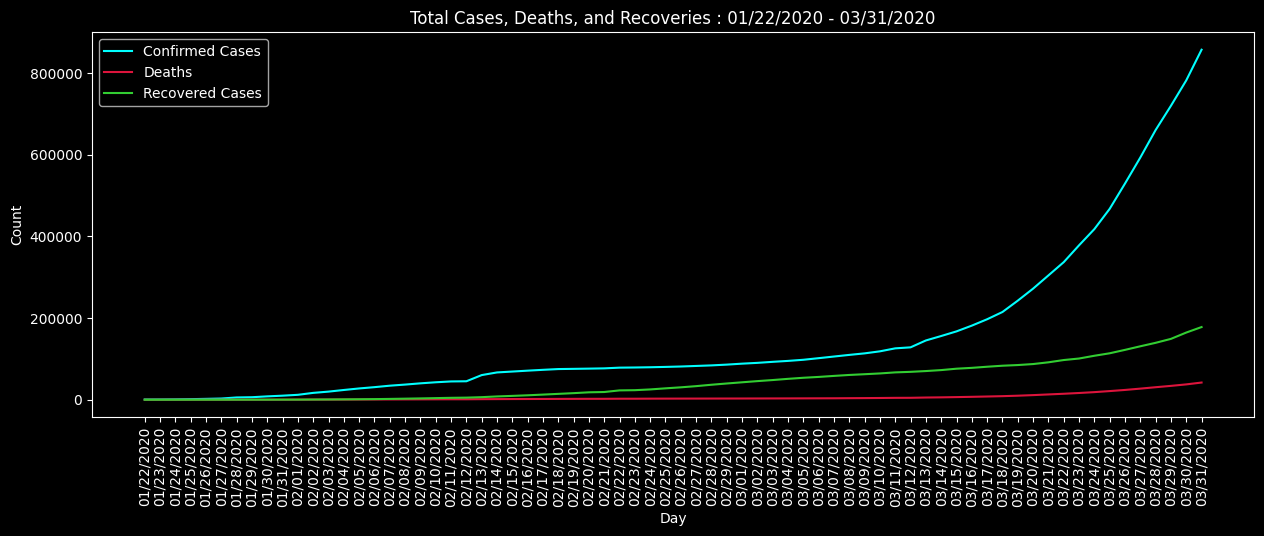

In [7]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases", color = 'cyan')
plt.plot(df_date_tots['Deaths'], label    = "Deaths", color = 'crimson')
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases", color = 'limegreen')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);

 ## Create new columns
 

In [8]:
##  Create a new column in the dataframe called “closed cases”
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered']
##  Create a new column in the dataframe called “active cases"
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']


## Create one plot showing the trend of number of active cases and closed cases

Text(0.5, 1.0, 'Active Cases vs Closed Cases COVID-19 : 01/22/2020 - 03/31/2020')

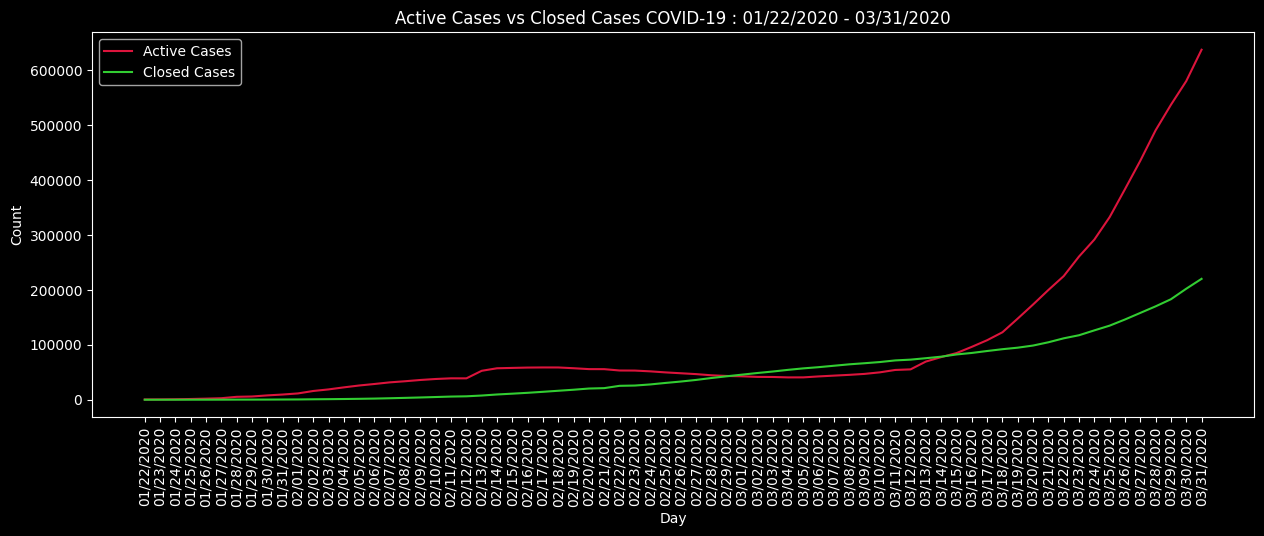

In [9]:

plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(df_date_tots['Active Cases'], label = "Active Cases", color = 'crimson')
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases", color = 'limegreen')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date)

## Growth Factor

In [10]:
growth_len_lst = len(date_lst) - 1; # 69
confirmed_lst = df_date_tots["Confirmed"];
death_lst = df_date_tots["Deaths"];
recovered_lst = df_date_tots["Recovered"];
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] ;
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i] ;
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i] ;
    recovGF_lst.append(recoveredGF);

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12252\331315844.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] ;
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12252\331315844.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deathGF = death_lst[i+1] / death_lst[i] ;
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_12252\331315844.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  re

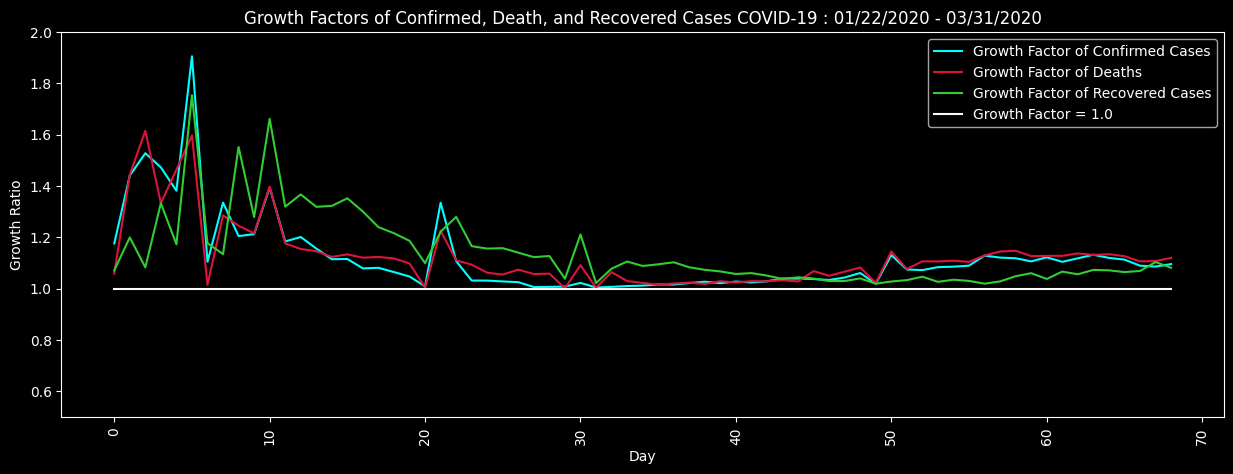

In [11]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases", color = 'cyan')
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths", color = 'crimson')
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases", color = 'limegreen')
x = []
for i in range((growth_len_lst)):
    x.append(1);
plt.plot(x, label = "Growth Factor = 1.0", color = 'snow')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +
          start_date +
          " - " +
          fin_date);

# Training model


In [12]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
10358,10359,03/31/2020,NaN,Afghanistan,174.0,4.0,5.0
10359,10360,03/31/2020,NaN,Albania,243.0,15.0,52.0
10360,10361,03/31/2020,NaN,Algeria,716.0,44.0,46.0
10361,10362,03/31/2020,NaN,Andorra,376.0,12.0,10.0
10362,10363,03/31/2020,NaN,Angola,7.0,2.0,1.0


In [13]:
days_since_lst = [];
for i in range(len(date_lst)):
    days_since_lst.append(i);
df_date_tots["Days Since:"] = days_since_lst;
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]];


In [14]:
## create a new column called “Days since” which tracks the number of days since the initial date.
days_since_lst = [];
for i in range(len(date_lst)):
    days_since_lst.append(i);
df_date_tots["Days Since:"] = days_since_lst;
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]];
     

In [15]:
## Take the earliest 85% of the dates as train and the rest as test
X = np.array(df_date_tots["Confirmed"])
# X is the world cases array
y = np.array(df_date_tots["Days Since:"]).reshape(-1,1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle = False)


In [17]:
## Try various linear regression methods discussed in class such as linear regression, ridge regression, svm, 
# and decision tree and plot the points and our fit line

lin_model = LinearRegression(fit_intercept = False);
lin_model.fit(y_train, X_train);
test_lin_pred = lin_model.predict(y_test)
lin_pred = lin_model.predict(y)
     

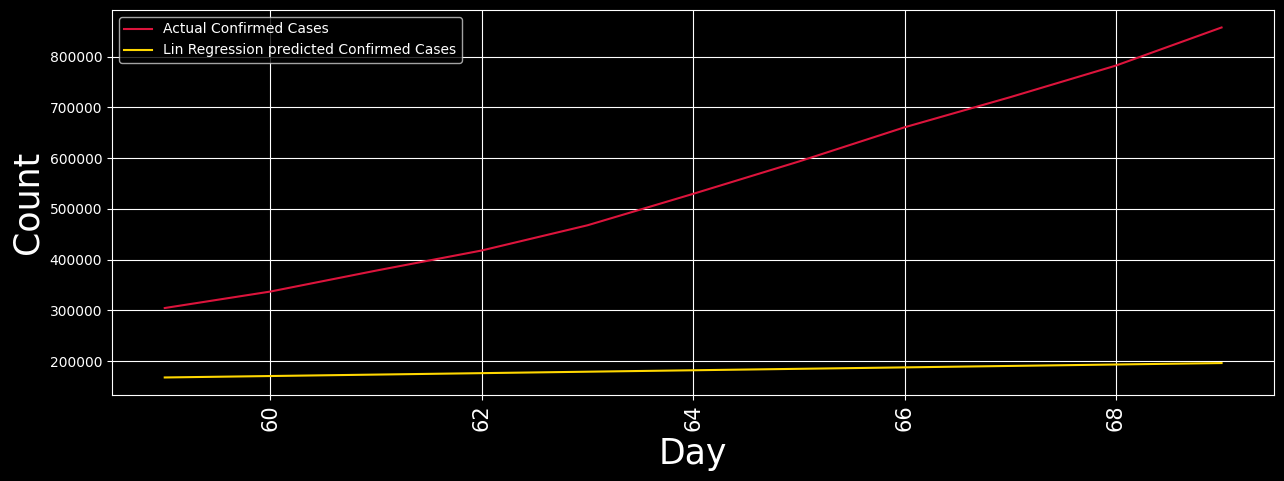

MAE: 368049.30417332525
MSE: 164288029427.18597


In [18]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

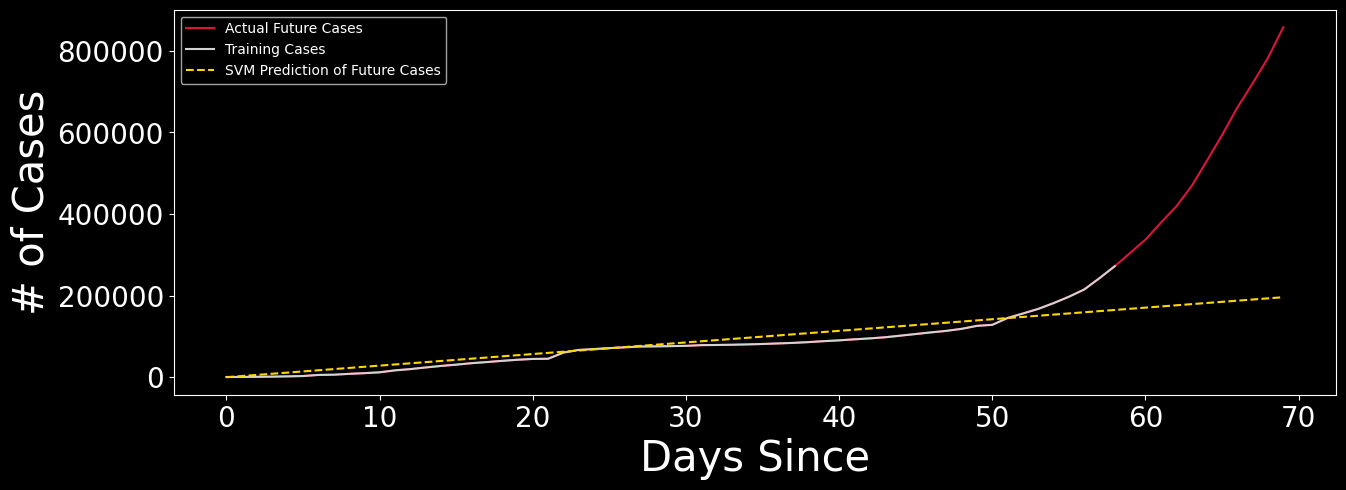

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')
plt.plot(y,
         lin_pred,
         label = 'SVM Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## Polinomial Regression


In [20]:
poly = PolynomialFeatures(degree=5)
poly_y_train = poly.fit_transform(y_train)
poly_y_test  = poly.fit_transform(y_test)
poly_y = poly.fit_transform(y)
     

In [21]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_y_train, X_train)
test_linear_pred = linear_model.predict(poly_y_test)
linear_pred = linear_model.predict(poly_y)

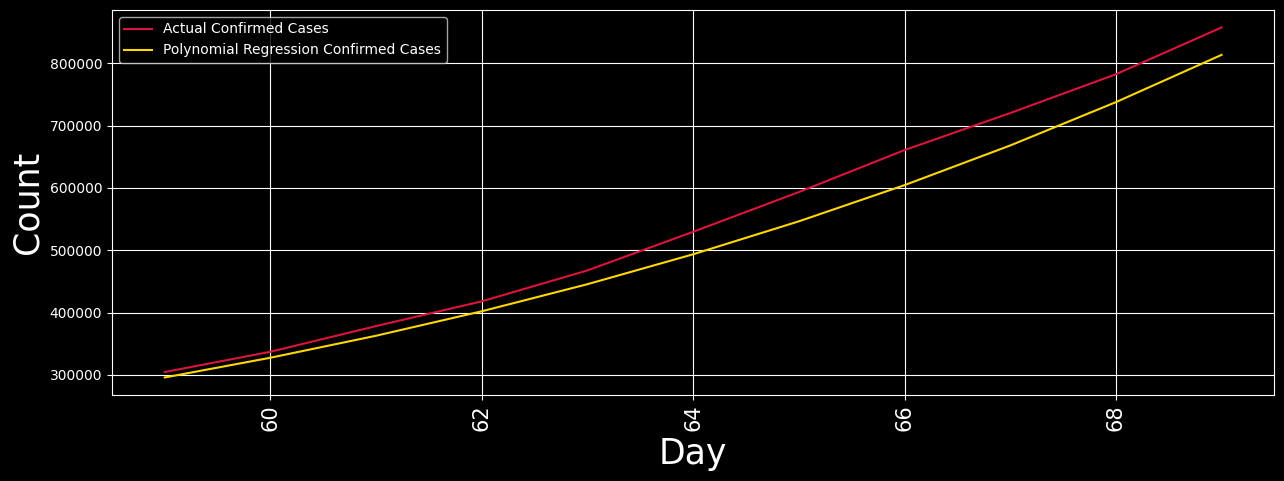

MAE: 31989.752421601093
MSE: 1314905574.043608


In [22]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         test_linear_pred,
         label = "Polynomial Regression Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_linear_pred, X_test))
print('MSE:',mean_squared_error(test_linear_pred, X_test))

## Ridge Regression

In [23]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(y_train, X_train);

print(bayesian_search.best_params_)
     

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-07}


In [24]:
y_test_ridge_pred = bayesian_search.predict(y_test);
y_ridge_pred = bayesian_search.predict(y);

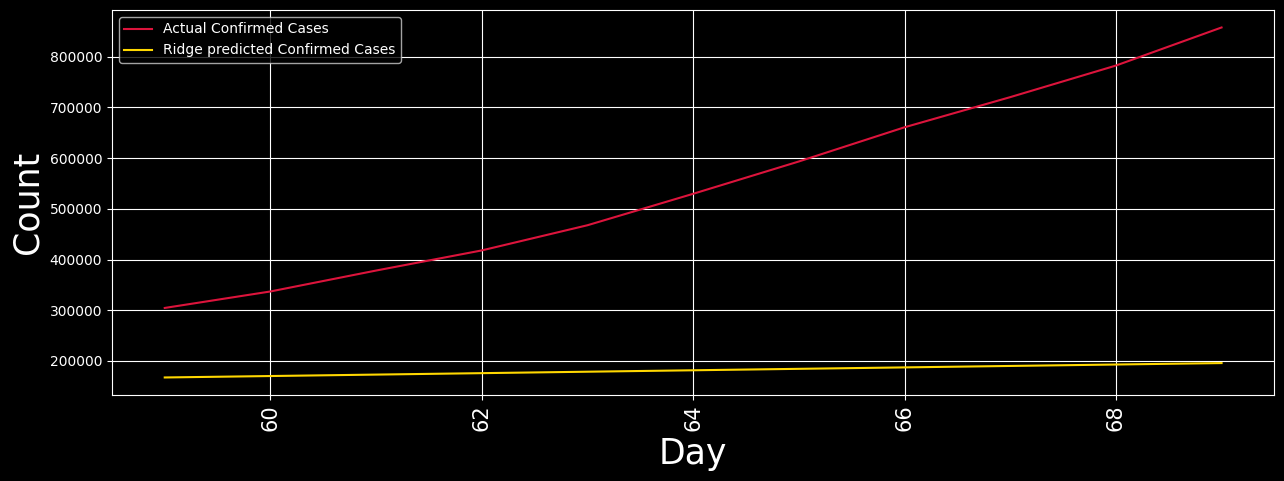

MAE: 368251.96606548753
MSE: 164440629513.48853


In [25]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

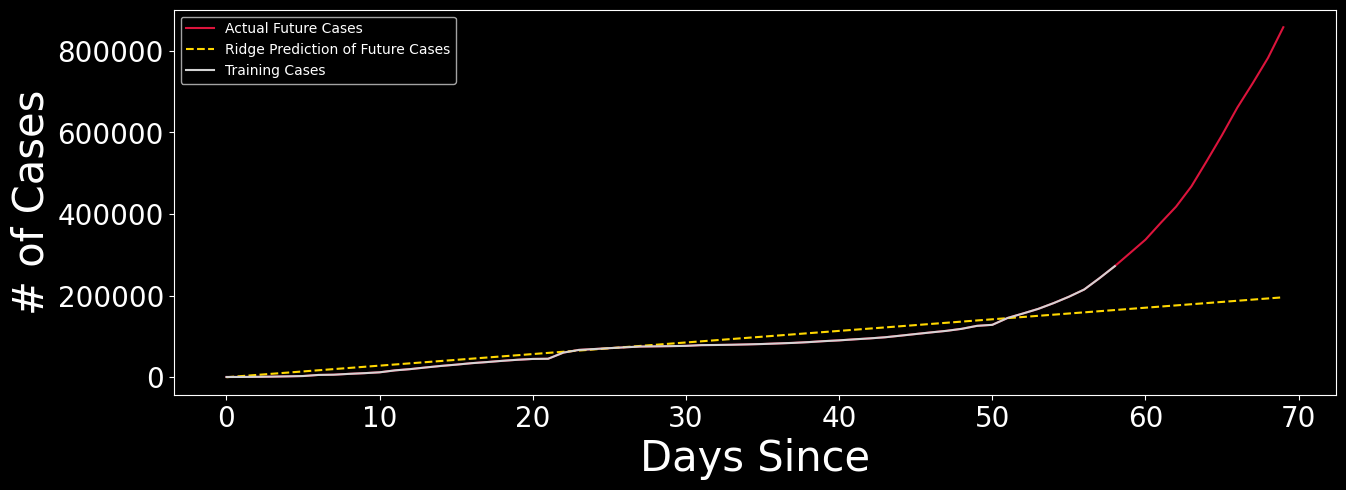

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# SVM


In [27]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10, 100];
gamma = [0.01, 0.1, 1];
epsilon = [0.01, 0.1, 1];
shrinking = [True, False];
svm_grid = {'kernel' :kernel,
           'C' : c,
           'gamma':gamma,
           'epsilon': epsilon,
           'shrinking': shrinking}

svm = SVR();
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3,
                               return_train_score = True)


svm_search.fit(y_train, X_train) # note how y_train had to be put first
print(svm_search.best_params_)

{'shrinking': True, 'kernel': 'poly', 'gamma': 0.1, 'epsilon': 1, 'C': 0.01}


In [28]:
y_pred_test = svm_search.predict(y_test)


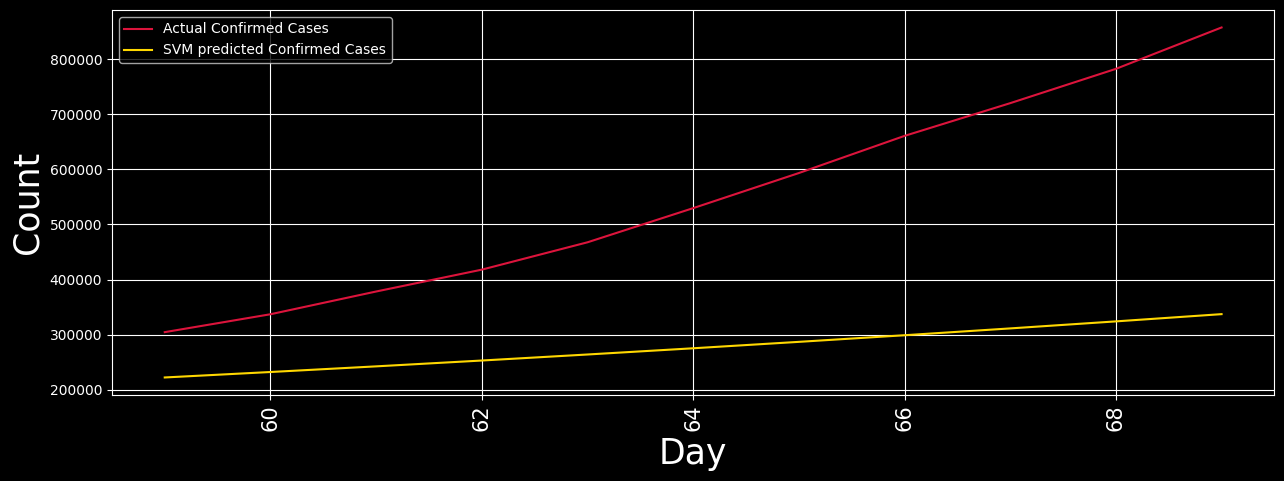

MAE: 272848.2852720001
MSE: 94740280629.26721


In [29]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         y_pred_test,
         label = "SVM predicted Confirmed Cases",
         color = 'gold')

plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(y_pred_test, X_test))
print('MSE:',mean_squared_error(y_pred_test, X_test))

In [30]:
y_pred = svm_search.predict(y)


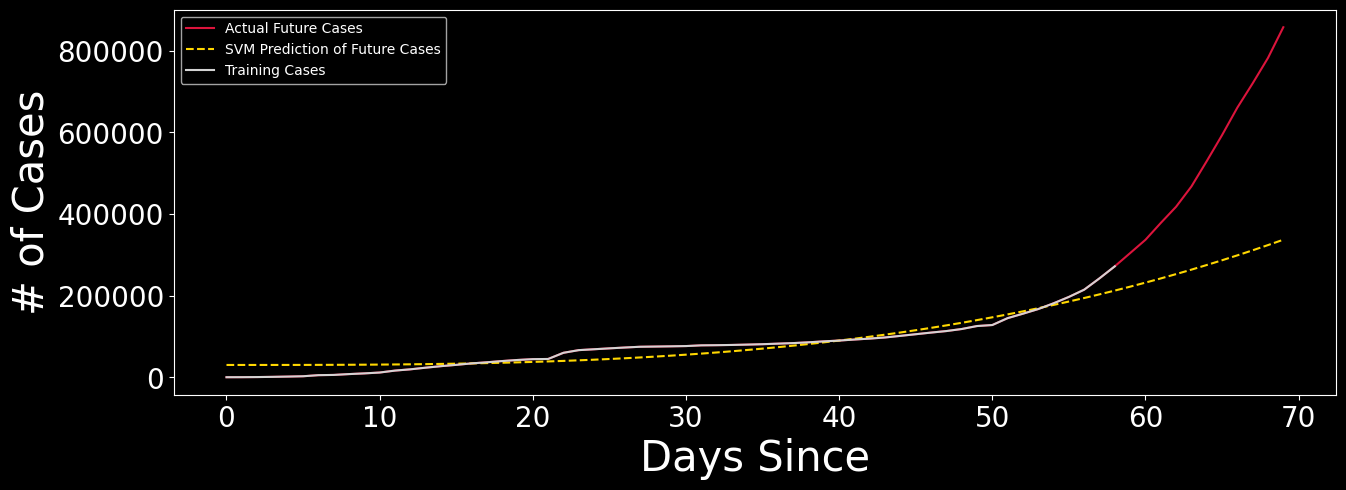

In [31]:
plt.figure(figsize=(15, 5))

plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')

plt.plot(y,
         y_pred,
         label = 'SVM Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()


## Polinomial Ridge Regression


In [32]:
bayesian_search_poly = RandomizedSearchCV(bayesian, bayesian_grid,scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)


In [33]:
bayesian_search_poly.fit(poly_y_train, X_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 1e-06, 'alpha_2': 1e-07, 'alpha_1': 1e-05}


In [34]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_y)

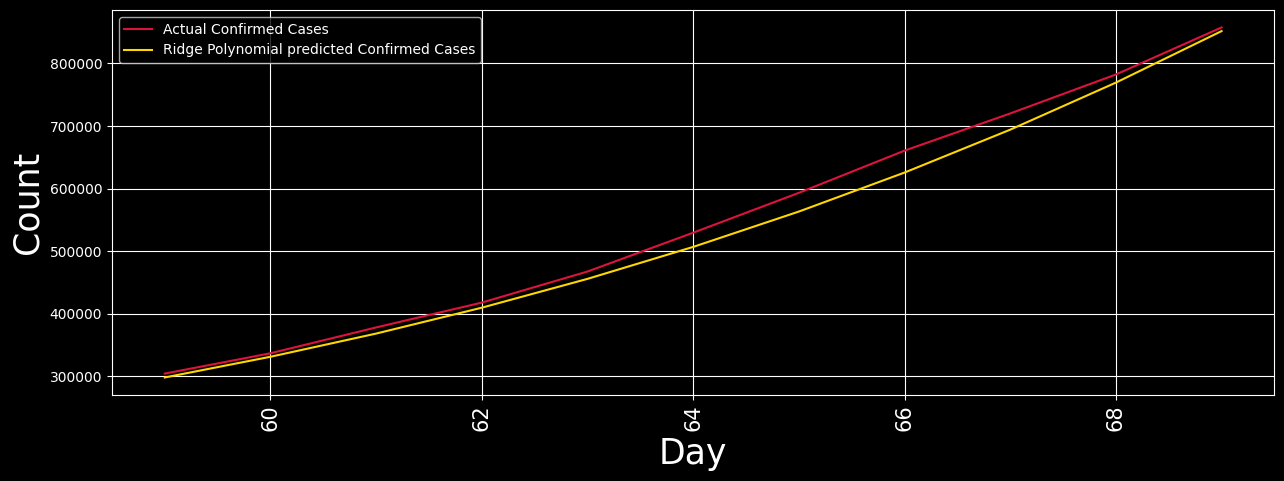

MAE: 15796.249587923003
MSE: 352570944.25750965


In [35]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test, X_test, label = "Actual Confirmed Cases", color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test, test_poly_bayesian_pred, label = "Ridge Polynomial predicted Confirmed Cases", color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, X_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, X_test))

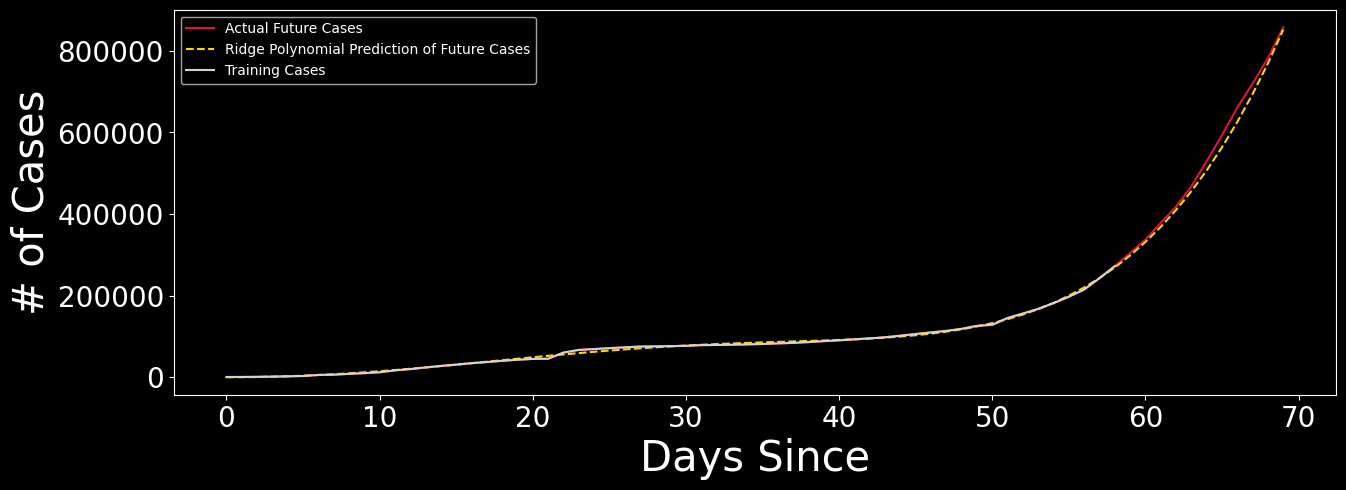

In [36]:

plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)

#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

##  Model Prediction Assessment


In [37]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_linear_pred, X_test))
print('\tMSE:',mean_squared_error(test_linear_pred, X_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, X_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, X_test))

Polynomial Regression 
	MAE: 31989.752421601093
	MSE: 1314905574.043608

Ridge Polynomial Regression 
	MAE: 15796.249587923003
	MSE: 352570944.25750965


The Ridge Polynomial Regression Model appears to be the most optimal model, as it exhibits lower Mean Absolute Error and Mean Squared Error.